In [1]:
import pyspark
from pyspark.sql.functions import col, count, isnan, when
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PySpark in Jupyter") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 11:48:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 11:48:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df = spark.read.csv('Dataset/df_new_2.csv', header=True, inferSchema=True)

In [3]:
# Create a new DataFrame df_coerce
df_coerce = df

In [4]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# we use Z-score to find outliers and extreme values

In [5]:
def count_outliers_iqr(df):
    # Define an empty dictionary to store the results
    results = {}
    
    # Loop through each numerical column in the DataFrame
    for column in df.columns:
        if df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double']:
            # Calculate quartiles for the column
            quartiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
            q1 = quartiles[0]
            q3 = quartiles[1]
            
            # Calculate IQR for the column
            iqr = q3 - q1
            
            # Calculate lower and upper bounds for outliers
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            # Count the number of values less than the lower bound or greater than the upper bound
            count_outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
            
            # Count the number of values less than the lower bound or greater than the upper bound by 3*IQR
            count_extremes = df.filter((col(column) < (q1 - 3 * iqr)) | (col(column) > (q3 + 3 * iqr))).count()
            
            # Add the counts to the dictionary
            results[column] = (count_outliers, count_extremes)
    
    # Return the dictionary containing counts of outliers and extreme values for each column
    return results




In [6]:
# Count outliers and extreme values for each column using IQR method for df_new_2
outlier_counts_iqr_2 = count_outliers_iqr(df)

# Display the header of the table
print("Column Name            | Outliers   | Extreme Values")
print("-------------------------------------------------")

# Display the counts of outliers and extreme values for each column using IQR method for df_new_2
for column, (outliers, extremes) in outlier_counts_iqr_2.items():
    print(f"{column: <22} | {outliers: <10} | {extremes: <13}")

Column Name            | Outliers   | Extreme Values
-------------------------------------------------
Diabetic               | 0          | 0            
AlcoholLevel           | 0          | 0            
HeartRate              | 9          | 6            
BodyTemperature        | 20         | 20           
Weight                 | 10         | 8            
MRI_Delay              | 0          | 0            
Age                    | 11         | 6            
Cognitive_Test_Scores  | 0          | 0            
Dementia               | 0          | 0            


In [7]:
from pyspark.sql.functions import col, when


def calculate_quartiles(df):
    quartiles_dict = {}
    for column in df.columns:
        if df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double']:
            quartiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
            quartiles_dict[column] = (quartiles[0], quartiles[1])
    return quartiles_dict

def coerce_outliers_extremes(df, quartiles_dict):
    for column in quartiles_dict:
        q1, q3 = quartiles_dict[column]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        lower_bound_extreme = q1 - 3 * iqr
        upper_bound_extreme = q3 + 3 * iqr
        
        # Handle outliers and extreme values differently
        df = df.withColumn(column,
                           when((col(column) < lower_bound) | (col(column) > upper_bound), 
                                when(col(column) < lower_bound, lower_bound).otherwise(upper_bound)).otherwise(col(column)))
        
        df = df.withColumn(column,
                           when((col(column) < lower_bound_extreme) | (col(column) > upper_bound_extreme), 
                                when(col(column) < lower_bound_extreme, lower_bound_extreme + (upper_bound_extreme - lower_bound_extreme) * 0.2).otherwise(upper_bound_extreme)).otherwise(col(column)))
    return df


# Calculate quartiles
quartiles_dict = calculate_quartiles(df_coerce)

# Coerce outliers and extremes
df_coerce_coerced = coerce_outliers_extremes(df_coerce, quartiles_dict)


In [8]:
# Count outliers and extreme values for each column using IQR method for df_coerce_coerced
outlier_counts_iqr_coerce = count_outliers_iqr(df_coerce_coerced)

# Display the header of the table
print("Column Name            | Outliers   | Extreme Values")
print("-------------------------------------------------")

# Display the counts of outliers and extreme values for each column using IQR method for df_coerce_coerced
for column, (outliers, extremes) in outlier_counts_iqr_coerce.items():
    print(f"{column: <22} | {outliers: <10} | {extremes: <13}")


Column Name            | Outliers   | Extreme Values
-------------------------------------------------
Diabetic               | 0          | 0            
AlcoholLevel           | 0          | 0            
HeartRate              | 0          | 0            
BodyTemperature        | 0          | 0            
Weight                 | 0          | 0            
MRI_Delay              | 0          | 0            
Age                    | 0          | 0            
Cognitive_Test_Scores  | 0          | 0            
Dementia               | 0          | 0            


In [9]:
# Before Coerce
# Select only the 4 columns of interest
selected_columns = ["HeartRate", "BodyTemperature", "Weight", "Age"]
selected_df = df.select(selected_columns)

# Compute summary statistics for the selected columns
summary_stats = selected_df.describe()

# Show the summary statistics
summary_stats.show()

+-------+------------------+-----------------+-----------------+-----------------+
|summary|         HeartRate|  BodyTemperature|           Weight|              Age|
+-------+------------------+-----------------+-----------------+-----------------+
|  count|              1000|             1000|             1000|             1000|
|   mean|            79.775|37.40251280583999|78.45932607626995|           75.911|
| stddev|16.623619332736162|13.48926851964244|51.26724143340815|14.35552716413298|
|    min|                 1|      22.06352268|       40.1030454|               60|
|    max|               320|       356.760164|      911.6282937|              251|
+-------+------------------+-----------------+-----------------+-----------------+



In [10]:
# After Coerce
# Select only the 4 columns of interest
selected_columns2 = ["HeartRate", "BodyTemperature", "Weight", "Age"]
selected_df2 = df_coerce_coerced.select(selected_columns2)

# Compute summary statistics for the selected columns
summary_stats2 = selected_df2.describe()

# Show the summary statistics
summary_stats2.show()


+-------+------------------+------------------+------------------+----------------+
|summary|         HeartRate|   BodyTemperature|            Weight|             Age|
+-------+------------------+------------------+------------------+----------------+
|  count|              1000|              1000|              1000|            1000|
|   mean|            79.319| 36.77309191878998| 74.81243313316996|          75.254|
| stddev|12.881971284868797|0.4760653485348972|15.294019982884423|9.62112519667269|
|    min|              35.0|       35.29124128|        40.1030454|            60.0|
|    max|             123.0|38.230790559999996|      124.81816464|           107.0|
+-------+------------------+------------------+------------------+----------------+



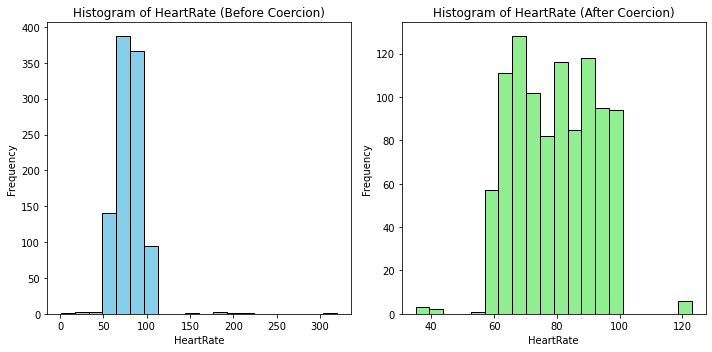

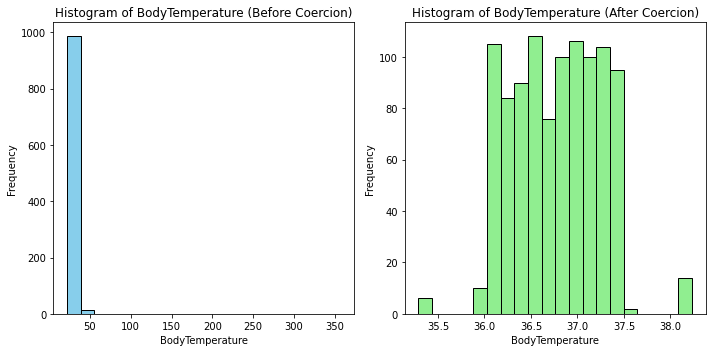

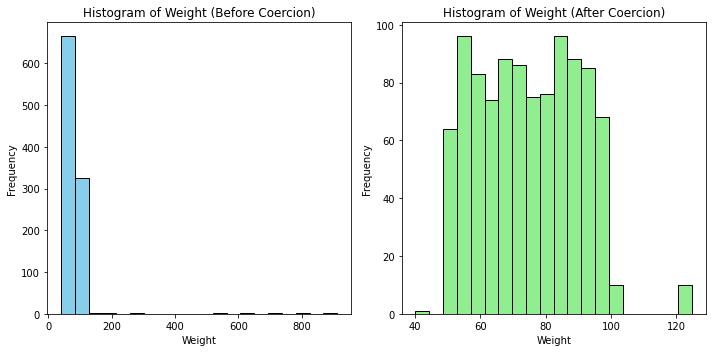

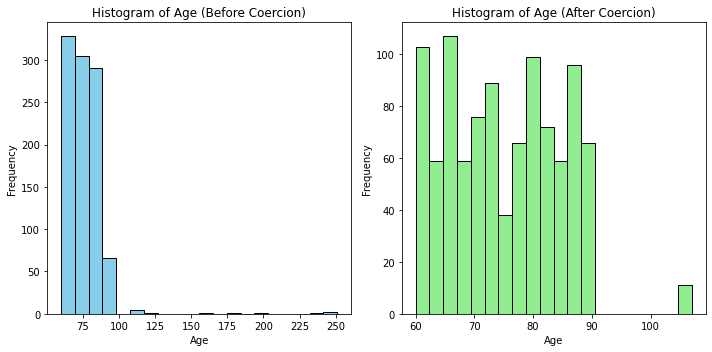

In [11]:
import matplotlib.pyplot as plt

# Define the variables of interest
variables = ["HeartRate", "BodyTemperature", "Weight", "Age"]

# Plot histograms for each variable before and after coercion
for variable in variables:
    # Plot histogram before coercion
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(df.select(variable).dropna().toPandas()[variable], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {variable} (Before Coercion)")
    plt.xlabel(variable)
    plt.ylabel("Frequency")

    # Plot histogram after coercion
    plt.subplot(1, 2, 2)
    plt.hist(df_coerce_coerced.select(variable).dropna().toPandas()[variable], bins=20, color='lightgreen', edgecolor='black')
    plt.title(f"Histogram of {variable} (After Coercion)")
    plt.xlabel(variable)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


In [12]:
df_new_3 = df_coerce_coerced

In [13]:
from pyspark.sql.functions import col, isnan

def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Total rows in the DataFrame
    total_rows = df.count()
    
    # Total columns in the DataFrame
    total_columns = len(schema)
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df.filter(col(column_name).isNotNull() & (~col(column_name).isin("Unknown", "None"))).count()
        
        # Count null values
        null_count = df.filter(col(column_name).isNull() | col(column_name).isin("Unknown", "None") | isnan(col(column_name))).count()
        
        columns_info.append({
            "column_name": column_name,
            "column_type": column_type,
            "non_null_count": non_null_count,
            "null_count": null_count
        })
    
    summary = {
        "total_rows": total_rows,
        "total_columns": total_columns,
        "columns_info": columns_info
    }
    
    return summary

# Call the function to describe the DataFrame df_new_3
summary_df_new_3 = spark_info(df_new_3)


In [14]:
columns_info = summary_df_new_3['columns_info']

print("DataFrame Schema and Summary:")
print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
print("-" * 60)
for column_info in columns_info:
    print(f"{column_info['column_name']:<25} {column_info['non_null_count']:<15} {column_info['null_count']:<10} {column_info['column_type']:<10}")


DataFrame Schema and Summary:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
Diabetic                  1000            0          double    
AlcoholLevel              1000            0          double    
HeartRate                 1000            0          double    
BodyTemperature           1000            0          double    
Weight                    1000            0          double    
MRI_Delay                 1000            0          double    
Age                       1000            0          double    
Education_Level           1000            0          string    
Gender                    1000            0          string    
Family_History            1000            0          string    
Smoking_Status            1000            0          string    
APOE_ε4                   1000            0          string    
Physical_Activity         1000            0          string    
Depression_St

In [15]:
# Save DataFrame to a CSV file
#df_new_3.write.csv("Dataset/df_new_3.csv", header=True)


In [16]:
# Continue in Part 3